In [177]:
import wikipedia
import nltk
from nltk import word_tokenize
from nltk import pos_tag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import brainiak.eventseg.event as event
from scipy.spatial.distance import squareform
from scipy.stats import wasserstein_distance, pearsonr
import seaborn as sns

import matplotlib.patches as patches


In [7]:
from afinn import Afinn
afinn = Afinn()

In [10]:
text_dir = '../paranoia_text/'

f = open(text_dir + 'stimuli_story_fulltext.txt',"r")
#print(f.read())
f = str(f.read())
idx_start = str.find(f,'The email')
f = f[idx_start:]

import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"
def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [95]:
def create_diag_mask(arr, diag_start=0, diag_limit=None):
    diag_mask = np.zeros_like(arr, dtype=bool)
    if diag_limit is None:
        diag_limit = find_diag_limit(arr)

    for k in range(diag_start, diag_limit):
        ix = kth_diag_indices(diag_mask, k)
        diag_mask[ix] = True

    return diag_mask
def kth_diag_indices(arr, k):
    row_ix, col_ix = np.diag_indices_from(arr)
    if k == 0:
        return row_ix, col_ix
    else:
        return row_ix[:-k], col_ix[k:]
def find_diag_limit(arr):
    for k in range(arr.shape[0]):
        d = np.diag(arr, k=k)
        if ~(d > 0).any():
            return k
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0]) == 1).astype(bool)
    return np.array([m[wi, :].mean(axis=0) for wi in w.T])

In [11]:
sentences = split_into_sentences(f)

In [12]:
def combine_sentence(sentences_new):
    a = ""
    for s in sentences_new: 
        a = a + s
    return a

In [13]:
n = 6  # group size
m = 4  # overlap size
sentences_new = [combine_sentence(sentences[i:i+n]) for i in range(0, len(sentences), n-m)]


In [21]:
dist = []
for sentence in sentences:

    #get affinity score
    score = afinn.score(sentence) / len(sentence.split(' '))
    
    print('Sentence' + ': ' + str(score))
    dist.append(score)

Sentence: 0.0
Sentence: -0.08333333333333333
Sentence: 0.06666666666666667
Sentence: 0.0
Sentence: 0.0
Sentence: 0.0
Sentence: 0.21428571428571427
Sentence: 0.0
Sentence: 0.0625
Sentence: 0.0
Sentence: 0.13333333333333333
Sentence: 0.047619047619047616
Sentence: 0.25
Sentence: 0.0
Sentence: 0.0
Sentence: 0.0
Sentence: 0.125
Sentence: 0.05555555555555555
Sentence: 0.0
Sentence: 0.16666666666666666
Sentence: 0.0
Sentence: 0.0
Sentence: 0.5
Sentence: 0.0
Sentence: 0.0
Sentence: 0.5
Sentence: 0.0
Sentence: 0.0
Sentence: 0.0
Sentence: 0.0
Sentence: 0.0
Sentence: 0.0
Sentence: 0.3333333333333333
Sentence: -0.02702702702702703
Sentence: 0.0
Sentence: 0.0
Sentence: 0.058823529411764705
Sentence: 0.0
Sentence: 0.1111111111111111
Sentence: 0.13333333333333333
Sentence: -0.06666666666666667
Sentence: -0.125
Sentence: 0.0
Sentence: 0.0
Sentence: -0.4
Sentence: 0.0
Sentence: -0.125
Sentence: 0.0
Sentence: -0.21428571428571427
Sentence: 0.0
Sentence: 0.2857142857142857
Sentence: 0.0
Sentence: 0.0
Se

In [27]:
T1 = 526
T2 = 452
T3 = 332

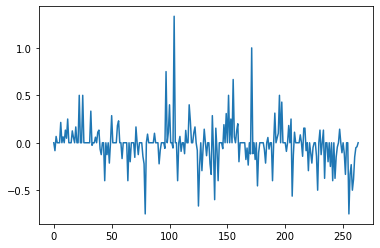

In [28]:
plt.plot(dist)

### Load in the dataframe with the labels

In [30]:
df = pd.read_csv('../paranoia_text/sentence_labels.csv')
df.head()

,run,sentence,sentence_offset_runsconcatenated,sentence_offset_inrun,mentalizing_event
0,story1,The email came late one afternoon as Dr Carmen...,11,11,0
1,story1,It had been a long day at the busy clinic in C...,18,18,0
2,story1,But the email’s strange subject line caught he...,23,23,0
3,story1,"“Fellow doctor, I need your help.”",26,26,1
4,story1,It was sent by someone named Dr John Torreson.,29,29,0


In [34]:
dist = []
for sentence in list(df['sentence']):

    #get affinity score
    score = afinn.score(sentence) / len(sentence.split(' '))
    
    #print('Sentence' + ': ' + str(score))
    dist.append(score)

In [37]:
df['sentiment'] = dist

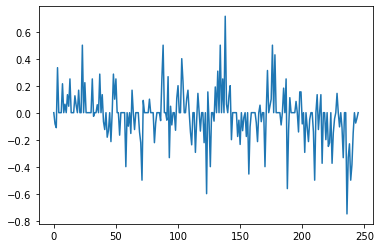

In [36]:
plt.plot(dist)


#### Expand the sentiment to last the length of time that corresponds to that sentence being represented

In [ ]:
i = 0
sent_label_df_r1['sentence_offset_inrun']
ment_r1 = np.zeros(T1)
ment_r2 = np.zeros(T2)
ment_r3 = np.zeros(T3)

In [44]:
sent_label_df = df
sent_label_df_r1 = sent_label_df[sent_label_df['run']=='story1'].reset_index()
sent_label_df_r2 = sent_label_df[sent_label_df['run']=='story2'].reset_index()
sent_label_df_r3 = sent_label_df[sent_label_df['run']=='story3'].reset_index()

In [45]:
i = 0
sent_label_df_r1['sentence_offset_inrun']
ment_r1 = np.zeros(T1)
ment_r2 = np.zeros(T2)
ment_r3 = np.zeros(T3)

In [48]:
df

,run,sentence,sentence_offset_runsconcatenated,sentence_offset_inrun,mentalizing_event,sentiment
0,story1,The email came late one afternoon as Dr Carmen...,11,11,0,0.000000
1,story1,It had been a long day at the busy clinic in C...,18,18,0,-0.083333
2,story1,But the email’s strange subject line caught he...,23,23,0,-0.111111
3,story1,"“Fellow doctor, I need your help.”",26,26,1,0.333333
4,story1,It was sent by someone named Dr John Torreson.,29,29,0,0.000000
...,...,...,...,...,...,...
241,story3,But another part of her felt wracked with guil...,1289,311,0,-0.150000
242,story3,"Carmen pictured Alba’s wide, trusting eyes;",1293,315,0,0.000000
243,story3,"If she left now, the decision would haunt her ...",1297,319,0,-0.076923
244,story3,"On the other hand, she wasn’t even sure if the...",1305,327,0,-0.041667


In [50]:
for i in range(1,len(sent_label_df_r1['sentence_offset_inrun'])-1):
    ment_r1[sent_label_df_r1['sentence_offset_inrun'].loc[i]:sent_label_df_r1['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r1['sentiment'].loc[i]
    
for i in range(1,len(sent_label_df_r2['sentence_offset_inrun'])-1):
    ment_r2[sent_label_df_r2['sentence_offset_inrun'].loc[i]:sent_label_df_r2['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r2['sentiment'].loc[i]
    
for i in range(1,len(sent_label_df_r3['sentence_offset_inrun'])-1):
    ment_r3[sent_label_df_r3['sentence_offset_inrun'].loc[i]:sent_label_df_r3['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r3['sentiment'].loc[i]
    

Text(979, 0.7, 'mean \nsentiment: -0.087')

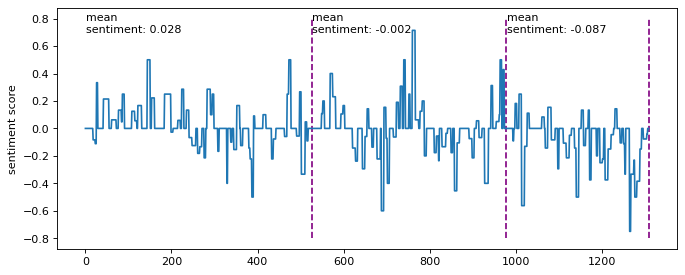

In [214]:
concat = []
concat.append(ment_r1)
concat.append(ment_r2)
concat.append(ment_r3)

from matplotlib.pyplot import figure

figure(figsize=(10, 4), dpi=80)

plt.plot(np.concatenate(concat,axis=0),linestyl)
plt.vlines(x=T1,ymin = -.8, ymax=.8, colors='purple',linestyles='--')
plt.vlines(x=T1+T2,ymin = -.8, ymax=.8, colors='purple',linestyles='--')
plt.vlines(x=T1+T2+T3,ymin = -.8, ymax=.8, colors='purple',linestyles='--')
plt.ylabel('sentiment score')
plt.text(0+1,.7,f'mean \nsentiment: {np.round(np.mean(ment_r1),3)}')
plt.text(T1+1,.7,f'mean \nsentiment: {np.round(np.mean(ment_r2),3)}')
plt.text(T1+T2+1,.7,f'mean \nsentiment: {np.round(np.mean(ment_r3),3)}')


In [94]:
df.to_csv('../paranoia_text/sentence_labels.csv')

### Run the HMM on the distribution of values

In [111]:
from nltools.data import Brain_Data, Adjacency
from sklearn.metrics import pairwise_distances


In [140]:
df.shape[0] #43
behav_sim_sum = np.array(df['sentiment'].T.corr())
behav_sim_sum

TypeError: corr() missing 1 required positional argument: 'other'

In [146]:
np.reshape(np.array(df['sentiment']),(-1,1))

(246, 1)

Text(0.5, 1.0, 'Sentiment Analysis')

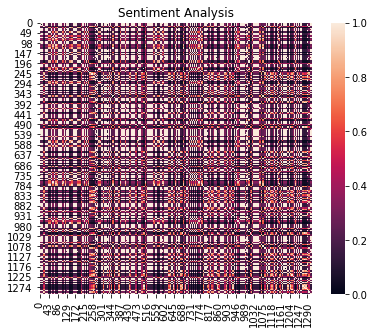

In [213]:
from scipy.stats import rankdata

behav_rank = rankdata(np.concatenate(concat,axis=0))

behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
behav_sim_nn = behav_sim_nn.distance_to_similarity()

behav_sim_nn.plot()
plt.title('Sentiment Analysis')


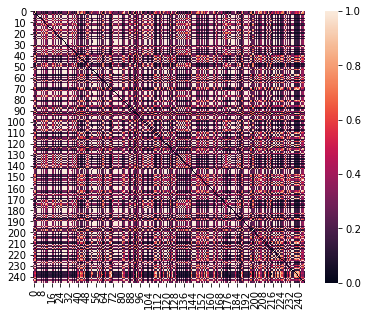

In [148]:
### Moving beyond the timepoints and looking at just the sentiment over each sentence

# from scipy.stats import rankdata

# behav_rank = rankdata(dist)

# behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
# #behav_sim_nn = behav_sim_nn.distance_to_similarity()

# behav_sim_nn.distance_to_similarity().plot()


In [154]:
squareform(behav_sim_nn.data)

array([[ 0. , 74. , 82. , ..., 72. , 59.5,  0. ],
       [74. ,  0. ,  8. , ...,  2. , 14.5, 74. ],
       [82. ,  8. ,  0. , ..., 10. , 22.5, 82. ],
       ...,
       [72. ,  2. , 10. , ...,  0. , 12.5, 72. ],
       [59.5, 14.5, 22.5, ..., 12.5,  0. , 59.5],
       [ 0. , 74. , 82. , ..., 72. , 59.5,  0. ]])

In [156]:
behav_sim_nn.data

array([ 74. ,  82. , 105.5, ...,  12.5,  72. ,  59.5])

In [184]:
n_events = np.arange(25,50)
wd = np.zeros(len(n_events))


for i, events in enumerate(tqdm(n_events, leave=False)):
    ev = event.EventSegment(events)
    try:
        ev.fit(behav_sim_nn.data)
    except:
        #if not tensor
        ev.fit(squareform(behav_sim_nn.data))
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
    w = np.zeros_like(ev.segments_[0])
    w[i1, i2] = 1
    mask = np.dot(w, w.T).astype(bool)

    # Create mask such that the maximum temporal distance 
    # for within and across correlations is the same
    local_mask = create_diag_mask(mask)
    
    within_vals = np.reshape(squareform(behav_sim_nn.data)[mask*local_mask], -1) 
    across_vals = np.reshape(squareform(behav_sim_nn.data)[~mask*local_mask], -1)
    wd[i] = wasserstein_distance(within_vals, across_vals)

  0%|          | 0/25 [00:00<?, ?it/s]

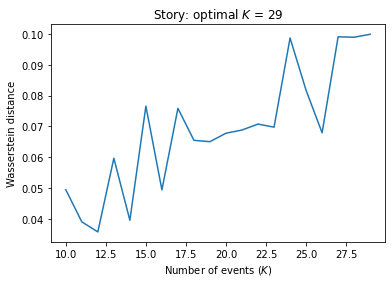

In [181]:
#plotting the Wasserstein distance

plt.plot(n_events, wd)
maxk_video = n_events[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Story: optimal $K$ = {maxk_video}')
# plt.savefig(FIG_DIR.joinpath('k_optimization_video.pdf'), bbox_inches='tight')
plt.show()

In [166]:
behav_sim_nn.data

array([ 74. ,  82. , 105.5, ...,  12.5,  72. ,  59.5])

In [206]:
#fitting the model to get the events from the story
ev = event.EventSegment(maxk_video)
ev.fit(squareform(behav_sim_nn.data))
story_events = reduce_model(squareform(behav_sim_nn.data), ev)

In [203]:
def draw_bounds(ax, model):
    bounds = np.where(np.diff(np.argmax(model.segments_[0], axis=1)))[0]
    bounds_aug = np.concatenate(([0], bounds, [model.segments_[0].shape[0]]))
    print(bounds_aug)
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle((bounds_aug[i], bounds_aug[i]),
                                 bounds_aug[i + 1] - bounds_aug[i],
                                 bounds_aug[i + 1] - bounds_aug[i],
                                 linewidth=1,
                                 edgecolor=EDGECOLOR,
                                 facecolor='none')
        ax.add_patch(rect)

    return ax,bounds


[   0   41   53   84  232  240  280  298  620  722  787  926  936 1012
 1029 1060 1082 1091 1110 1128 1152 1162 1195 1206 1218 1227 1264 1278
 1292 1310]


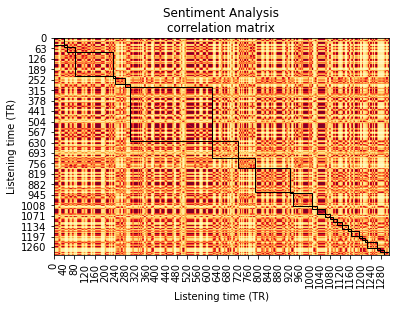

In [207]:
fig, ax = plt.subplots()

cmap = "YlOrRd"
EDGECOLOR='black'
sns.heatmap(squareform(behav_sim_nn.data), 
            vmin=0, 
            vmax=1, 
            cmap=cmap, 
            cbar=False, 
            ax=ax)
ax.set_title('Sentiment Analysis\ncorrelation matrix')
ax.set_ylabel('Listening time (TR)')
ax.set_xlabel('Listening time (TR)')
for spine in ax.spines.values():
    spine.set_visible(True)

draw_bounds(ax, ev)
ax.collections[0].remove()
ax.imshow(squareform(behav_sim_nn.data), aspect='auto', cmap=cmap)


### Testing manually

In [196]:
#fitting the model to get the events from the story

#fitting the model to get the events from the story
ev = event.EventSegment(22)
ev.fit(squareform(behav_sim_nn.data))
story_events = reduce_model(squareform(behav_sim_nn.data), ev)

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
/dartfs-hpc/rc/home/9/f004p59/.conda/envs/brainiak_py37/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[   0  184  202  233  240  280  298  721  787  925  936 1007 1013 1029
 1060 1082 1119 1142 1146 1147 1195 1219 1254 1310]


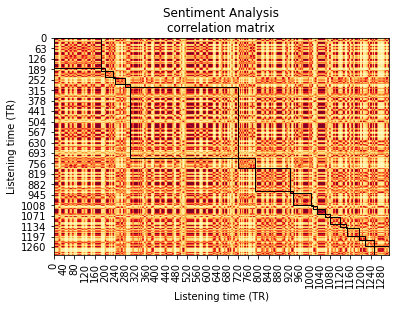

In [204]:
fig, ax = plt.subplots()

cmap = "YlOrRd"
EDGECOLOR='black'
sns.heatmap(squareform(behav_sim_nn.data), 
            vmin=0, 
            vmax=1, 
            cmap=cmap, 
            cbar=False, 
            ax=ax)
ax.set_title('Sentiment Analysis\ncorrelation matrix')
ax.set_ylabel('Listening time (TR)')
ax.set_xlabel('Listening time (TR)')
for spine in ax.spines.values():
    spine.set_visible(True)

ax,bounds = draw_bounds(ax, ev)
ax.collections[0].remove()
ax.imshow(squareform(behav_sim_nn.data), aspect='auto', cmap=cmap)


In [205]:
bounds

array([ 184,  202,  233,  240,  280,  298,  721,  787,  925,  936, 1007,
       1013, 1029, 1060, 1082, 1119, 1142, 1146, 1147, 1195, 1219, 1254])

In [209]:
squareform(behav_sim_nn.data).shape

(1310, 1310)

In [210]:
np.save(f'sentiment_analysis_boundaries_nevents_{maxk_video}.npy',bounds)
np.save(f'sentiment_analysis_matrix.npy',squareform(behav_sim_nn.data))
